# Exercise H5.1: Cross-validation

## Load Training and Test Data

In [48]:
import numpy as np

Xy = np.loadtxt("TrainingRidge.csv", skiprows=1, delimiter=",").T
X, y = Xy[:2], Xy[2]
Xy_val = np.loadtxt("ValidationRidge.csv", skiprows=1, delimiter=",").T
X_val, y_val = Xy_val[:2], Xy_val[2]

In [49]:
X.shape

(2, 200)

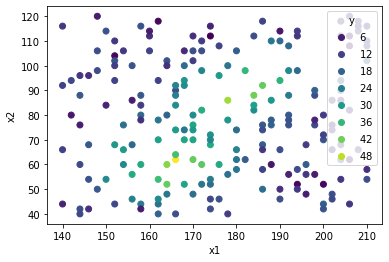

In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_scatter(X, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    scatter = ax.scatter(x=X[0], y=X[1], c=y)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="y")
    
plot_scatter(X, y)

## Sphering the Training Data

In [51]:
Lambda, E = np.linalg.eig(np.cov(X))

In [52]:
Lambda.shape

(2,)

In [53]:
Xc = X - np.mean(X, axis=1).reshape(-1, 1)
np.mean(Xc, axis=1)

array([-1.25055521e-14,  0.00000000e+00])

In [54]:
Xs = np.diag(Lambda**(-0.5)).T @ E.T @ Xc

In [55]:
Xs.shape

(2, 200)

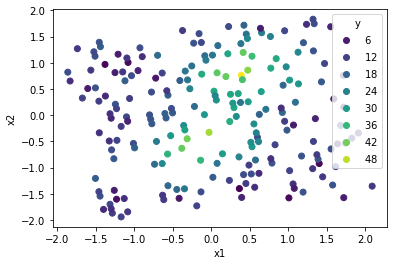

In [56]:
plot_scatter(Xs, y)

In [57]:
np.cov(Xs)

array([[1.00000000e+00, 2.47287342e-17],
       [2.47287342e-17, 1.00000000e+00]])

## Sphere Validation Data

Using same mean and sphering transformation as for the training set:

In [58]:
Xc_val = X_val - np.mean(X, axis=1).reshape(-1, 1)
Xs_val = np.diag(Lambda**(-0.5)).T @ E.T @ Xc_val

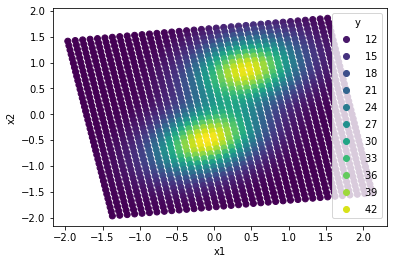

In [59]:
plot_scatter(Xs_val, y_val)

## Using monomials to predict labels

In [60]:
max_k = 9

In [61]:
def phi(x, max_k=max_k):
    """Computes the monomials up to degree d for x"""
    result = []
    for k in range(max_k + 1):
        l = k
        m = 0
        while l >= 0:
            x1, x2 = x
            
            result.append(x1**l * x2**m)
            
            l = l - 1
            m = m + 1
    return np.array(result)

phi(Xs[:,0]).size

55

In [62]:
# "input matrix", values of monomials for validation data
Phi_val = np.apply_along_axis(phi, 0, Xs_val)
Phi_val.shape

(55, 1476)

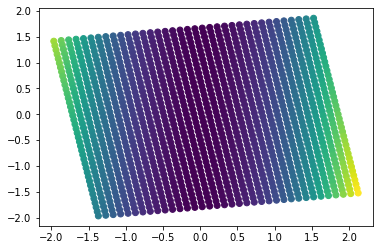

In [63]:
def plot_monomial(X, Phi, i, ax):    
    ax.scatter(x=Xs_val[0], y=Xs_val[1], c=Phi_val[i])

fig, ax = plt.subplots()
plot_monomial(Xs_val, Phi_val, 3, ax)

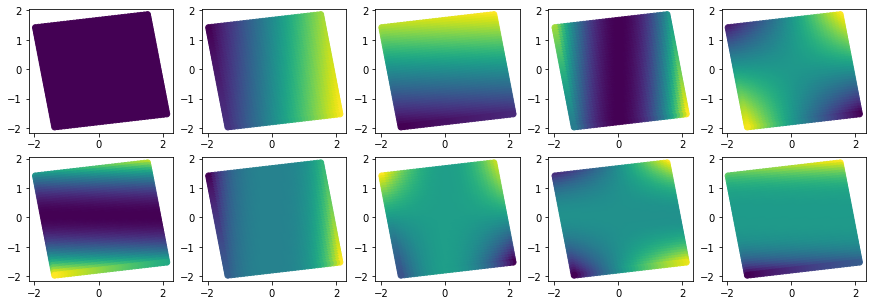

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    plot_monomial(Xs_val, Phi_val, i, ax)

## Calculate optimal weights for prediction function

In [65]:
w_opt = np.linalg.inv(Phi_val @ Phi_val.T) @ Phi_val @ y_val.reshape(-1, 1)
w_opt

array([[ 3.18029202e+01],
       [ 5.25327207e+00],
       [-1.80841690e+01],
       [-3.37036251e+01],
       [ 3.03273699e+01],
       [ 1.78602808e+01],
       [-4.01686759e+00],
       [ 2.48435108e+01],
       [ 4.90086920e+00],
       [ 4.29034429e+01],
       [ 1.65842868e+01],
       [-3.03301661e+01],
       [ 3.08172752e+00],
       [-3.84577092e+00],
       [-3.07702133e+01],
       [ 4.04759990e-01],
       [-1.20004687e+01],
       [-8.23750228e+00],
       [-2.93805889e+01],
       [ 3.80957230e+00],
       [-3.11329629e+01],
       [-2.97686178e+00],
       [ 9.12232545e+00],
       [-5.32250760e+00],
       [ 7.49907099e+00],
       [ 1.00507081e+01],
       [-5.73250644e+00],
       [ 1.17805661e+01],
       [ 2.32440553e-01],
       [ 2.59870681e+00],
       [ 3.35569735e+00],
       [ 6.28256929e+00],
       [ 1.39090425e+00],
       [ 1.30119581e+01],
       [-4.39011878e+00],
       [ 9.29132655e+00],
       [ 1.36404227e-01],
       [-8.47906296e-01],
       [ 8.0

In [66]:
def predict_y(x, w=w_opt):
    return w.T @ phi(x)

print("x:", X_val[:,0])
print("predicted:", predict_y(X_val[:,0])[0])
print("actual:", y_val[0])
print()
print("x:", X_val[:,1000])
print("predicted:", predict_y(X_val[:,1000])[0])
print("actual:", y_val[1000])

x: [140.  40.]
predicted: -3.148045635496999e+18
actual: 10.4475482124931

x: [196.  94.]
predicted: -1.498532384668082e+20
actual: 19.3617905471837


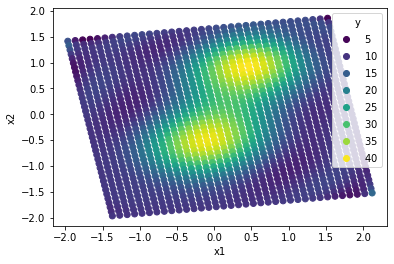

In [67]:
y_pred = [predict_y(x) for x in Xs_val.T]
plot_scatter(Xs_val, y_pred)

## Apply weight-decay term to avoid overfitting

In [68]:
def compute_w_ridge(X, y, reg_strength=1):  
    w_ridge = np.linalg.inv(X @ X.T + reg_strength * np.identity(X.shape[0])) @ X @ y.reshape(-1, 1)
    return w_ridge
    
w_ridge = compute_w_ridge(Phi_val, y_val)

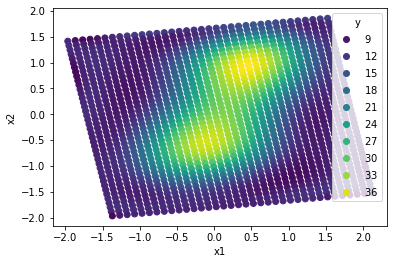

In [69]:
y_pred = [predict_y(x, w=w_ridge) for x in Xs_val.T]
plot_scatter(Xs_val, y_pred)

## Find the best regularization strenght using cross-validation

In [70]:
reg_strengths = [10**rs for rs in np.arange(-4, 4 + 0.1, 0.1)]

In [154]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)

average_MSEs = []
stds = []
for rs in reg_strengths:
    print(f"Cross-validation for regularization strength {rs}")
    MSEs = []
    for train_index, test_index in kf.split(Xs.T):
        X_train, y_train = Xs[:,train_index], y[train_index]
        X_test, y_test = Xs[:,test_index], y[test_index]
        
        Phi_fold = np.apply_along_axis(phi, 0, X_train)

        w_ridge_fold = compute_w_ridge(Phi_fold, y_train, reg_strength=rs)

        y_pred = np.array([predict_y(x, w=w_ridge_fold) for x in X_test.T]).flatten()
        MSE = 1/len(y_test) * sum((y_pred - y_test)**2)
        MSEs.append(MSE)
        
    average_MSEs.append(np.mean(MSEs))
    stds.append(np.std(MSEs))

Cross-validation for regularization strength 0.0001
Cross-validation for regularization strength 0.00012589254117941674
Cross-validation for regularization strength 0.00015848931924611142
Cross-validation for regularization strength 0.0001995262314968881
Cross-validation for regularization strength 0.0002511886431509582
Cross-validation for regularization strength 0.00031622776601683826
Cross-validation for regularization strength 0.00039810717055349773
Cross-validation for regularization strength 0.000501187233627273
Cross-validation for regularization strength 0.0006309573444801943
Cross-validation for regularization strength 0.0007943282347242829
Cross-validation for regularization strength 0.001000000000000002
Cross-validation for regularization strength 0.00125892541179417
Cross-validation for regularization strength 0.0015848931924611173
Cross-validation for regularization strength 0.001995262314968885
Cross-validation for regularization strength 0.0025118864315095872
Cross-valid

<ErrorbarContainer object of 3 artists>

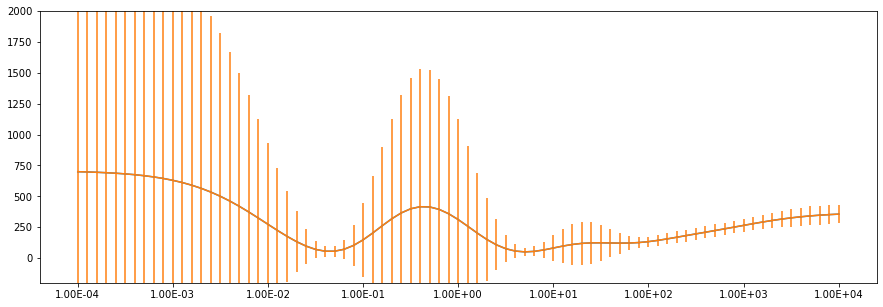

In [155]:
fig, ax = plt.subplots(figsize=(15, 5))

x = np.log10(reg_strengths)
ax.plot(x, average_MSEs)
ax.set_xticks(np.log10(reg_strengths)[::10])
ax.set_xticklabels([f"{rs:.2E}" for rs in reg_strengths][::10])
ax.set_ylim([-200, 2000])
ax.errorbar(x, average_MSEs, yerr=stds)

In [156]:
rs_opt = reg_strengths[np.argmin(average_MSEs)]
rs_opt

5.011872336272776

In [157]:
best_rss = np.array(reg_strengths)[np.argsort(average_MSEs)][:10]
print("Best strengths:", [f"{rs:.2F}" for rs in best_rss])
print("Respective MSEs:", np.sort(average_MSEs)[:10])

Best strengths: ['5.01', '6.31', '0.05', '0.04', '3.98', '7.94', '0.03', '0.06', '3.16', '10.00']
Respective MSEs: [50.30549914 54.3958375  55.59627183 55.76387437 56.88169786 66.04451497
 70.36184114 71.2436803  76.01733726 81.54202279]


In [158]:
Phi = np.apply_along_axis(phi, 0, Xs)
w_ridge_opt = compute_w_ridge(Phi, y, reg_strength=rs_opt)

In [162]:
y_pred = np.array([predict_y(x, w=w_ridge_opt) for x in Xs_val.T]).flatten()

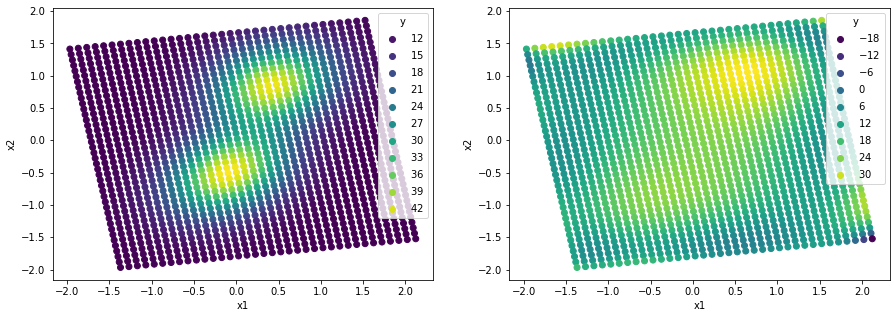

In [163]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

plot_scatter(Xs_val, y_val, axes[0])
plot_scatter(Xs_val, y_pred, axes[1])

In [164]:
MSE = 1/len(y_val) * sum((y_pred - y_val)**2)
MSE

24.660858681245198